# **Read and visualize the dataset:**

In [1]:
# Connect to Google Drive.

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Import and extract the zipped file of the dataset.

import zipfile
zip_file_path = '/content/drive/My Drive/NewDataset_MG_1.zip'

extract_path = '/content/extracted_files'

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
  zip_ref.extractall(extract_path)

In [3]:
# Install pyradiomics and other needed libraries.

! pip install pyradiomics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.5/34.5 MB 12.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Discarding https://files.pythonhosted.org/packages/03/c1/20fc2c50ab1e3304da36d866042a1905a2b05a1431ece35448ab6b4578f2/pyradiomics-3.1.0.tar.gz (from https://pypi.org/simple/pyradiomics/): Requested pyradiomics from https://files.pythonhosted.org/packages/03/c1/20fc2c50ab1e3304da36d866042a1905a2b05a1431ece35448ab6b4578f2/pyradiomics-3.1.0.tar.gz has inconsistent version: expected '3.1.0', but metadata has '3.0.1a1'
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.5/34.5 MB 47.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 96.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.3/52.3 MB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117

In [4]:
import SimpleITK as sitk
from radiomics import featureextractor

In [5]:
import os
import cv2
import glob
import zipfile
import skimage
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

In [6]:
# Define the dataset path.

dataset_path = '/content/extracted_files/NewDataset_MG/'

In [7]:
all_folder_path = glob.glob('{}*'.format(dataset_path))
all_folder_path

['/content/extracted_files/NewDataset_MG/ACR 2',
 '/content/extracted_files/NewDataset_MG/ACR 3',
 '/content/extracted_files/NewDataset_MG/ACR 4',
 '/content/extracted_files/NewDataset_MG/ACR 1']

In [8]:
all_folder_path.sort()
all_folder_path

['/content/extracted_files/NewDataset_MG/ACR 1',
 '/content/extracted_files/NewDataset_MG/ACR 2',
 '/content/extracted_files/NewDataset_MG/ACR 3',
 '/content/extracted_files/NewDataset_MG/ACR 4']

/content/extracted_files/NewDataset_MG/ACR 1/MG_46.tiff
/content/extracted_files/NewDataset_MG/ACR 1/MG_7.tiff
/content/extracted_files/NewDataset_MG/ACR 1/MG_73.tiff
/content/extracted_files/NewDataset_MG/ACR 1/MG_80.tiff
/content/extracted_files/NewDataset_MG/ACR 1/MG_95.tiff
/content/extracted_files/NewDataset_MG/ACR 1/MG_19.tiff
/content/extracted_files/NewDataset_MG/ACR 1/MG_21.tiff
/content/extracted_files/NewDataset_MG/ACR 1/MG_35.tiff
/content/extracted_files/NewDataset_MG/ACR 1/MG_15.tiff
/content/extracted_files/NewDataset_MG/ACR 1/MG_12.tiff
/content/extracted_files/NewDataset_MG/ACR 1/MG_52.tiff
/content/extracted_files/NewDataset_MG/ACR 1/MG_40.tiff
/content/extracted_files/NewDataset_MG/ACR 1/MG_37.tiff
/content/extracted_files/NewDataset_MG/ACR 1/MG_8.tiff
/content/extracted_files/NewDataset_MG/ACR 1/MG_50.tiff
/content/extracted_files/NewDataset_MG/ACR 1/MG_1.tiff
/content/extracted_files/NewDataset_MG/ACR 1/MG_57.tiff
/content/extracted_files/NewDataset_MG/ACR 1/MG_22.

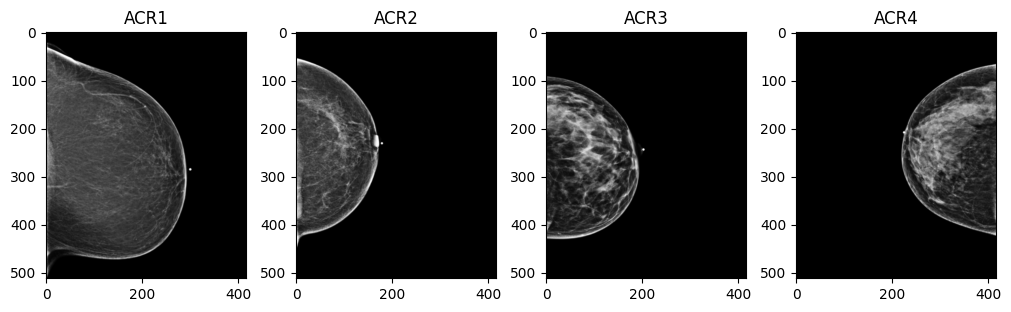

In [9]:
# Read and visualize the dataset.

fig1 = plt.figure(figsize =(10,5),constrained_layout=True)
gs1 = GridSpec(1,4, figure=fig1)

for i,each_fol in enumerate(all_folder_path):
    fol_in_path = glob.glob('{}*'.format(each_fol+ '/'))
    case  = os.listdir(each_fol+'/')
    #print(case)
    #print(len(fol_in_path))

    for fol in (fol_in_path[:]) :
        print(fol)
        img = skimage.io.imread(fol)

    ax1 = fig1.add_subplot(gs1[0,i])
    ax1.imshow(img,'gray')
    ax1.title.set_text("ACR"+str(i+1))
    ax1.axis("on")

plt.show()

In [10]:
# Visualize an image as a sample.
img = skimage.io.imread('/content/extracted_files/NewDataset_MG/ACR 4/MG_83.tiff')
plt.imshow(img,'gray')

In [11]:
# Create a binary mask.
masked_a=np.ma.masked_equal(img,0.0,copy=True)
plt.imshow(masked_a,'gray')

In [13]:
# Evaluate the properties of the sample image.

print(img.max())
print(img.min())
print(masked_a.mean())

# **Extract relevant features**

In [14]:
# Preprocess images to remove the skin tissue and the possible artifacts.

def preprocess(image):

    # I have used a smaller kernel (15x15) for less aggressive erosion compared to that of Prof. Afifehzadeh.

    kernel = np.ones((15,15), np.uint8)
    eroded_img = cv2.erode(image, kernel)
    zeros_img = np.zeros(eroded_img.shape, dtype='uint8')
    mask_of_eroded_img = np.ma.masked_where(eroded_img != 0, zeros_img, copy=True)
    image = (mask_of_eroded_img.mask) * image
    return image

In [15]:
# Create feature list.

features_list = []
target_list = []


for i,each_fol in enumerate(all_folder_path):
    fol_in_path = glob.glob('{}*'.format(each_fol+ '/'))
    case  = os.listdir(each_fol+'/')
    #print(case)
    #print(len(fol_in_path))

    for fol in (fol_in_path[:]) :
        print(fol)

        # Load the TIFF image.
        image = skimage.io.imread(fol)

        # Display the original image.
        plt.figure(figsize=(10, 5))

        plt.subplot(1, 3, 1)
        plt.imshow(image, cmap='gray')  # Use 'gray' colormap for grayscale images.
        plt.title("Original Image")

        image = preprocess(image) # Preprocess is defined in previous cell.

        print(image.max())

        # Normalize the 8-bit image to the range [0, 1]
        image_normalized = image / (image.max())

        # Display the eroded image.
        plt.subplot(1, 3, 2)
        plt.imshow(image, cmap='gray')  # Use 'gray' colormap for grayscale images
        plt.title("eroded Image")

        binary_mask =image  # Create a binary mask
        binary_mask [binary_mask > 0]=1

        # Display the binary mask.
        plt.subplot(1, 3, 3)
        plt.imshow(binary_mask, cmap='gray')
        plt.title("Binary Mask")

        plt.show()

        mask = binary_mask

        # Convert NumPy arrays to SimpleITK images
        image_sitk = sitk.GetImageFromArray(image)
        mask_sitk = sitk.GetImageFromArray(mask)

        # Set metadata
        image_sitk.SetSpacing([1.0, 1.0])
        image_sitk.SetOrigin([0.0, 0.0])
        image_sitk.SetDirection([1.0, 0.0, 0.0, 1.0])

        mask_sitk.SetSpacing(image_sitk.GetSpacing())
        mask_sitk.SetOrigin(image_sitk.GetOrigin())
        mask_sitk.SetDirection(image_sitk.GetDirection())

        # Initialize the feature extractor
        extractor = featureextractor.RadiomicsFeatureExtractor()

        # Extract features
        features = extractor.execute(image_sitk, mask_sitk)


        features_list.append(features)
        target_list.append(i)

Output hidden; open in https://colab.research.google.com to view.

In [16]:
len(features_list)

445

# **Save the features in a excel format**

In [25]:
# Convert features to a DataFrame
data_frame = pd.DataFrame(features_list)
data_frame

,diagnostics_Versions_PyRadiomics,diagnostics_Versions_Numpy,diagnostics_Versions_SimpleITK,diagnostics_Versions_PyWavelet,diagnostics_Versions_Python,diagnostics_Configuration_Settings,diagnostics_Configuration_EnabledImageTypes,diagnostics_Image-original_Hash,diagnostics_Image-original_Dimensionality,diagnostics_Image-original_Spacing,...,original_glszm_SmallAreaHighGrayLevelEmphasis,original_glszm_SmallAreaLowGrayLevelEmphasis,original_glszm_ZoneEntropy,original_glszm_ZonePercentage,original_glszm_ZoneVariance,original_ngtdm_Busyness,original_ngtdm_Coarseness,original_ngtdm_Complexity,original_ngtdm_Contrast,original_ngtdm_Strength
0,v3.0.1,2.0.2,2.4.1,1.8.0,3.11.12,"{'minimumROIDimensions': 2, 'minimumROISize': ...",{'Original': {}},262c97abecd2b9fd242b69a7284b1b0047173944,2D,"(1.0, 1.0)",...,1.0296222739020919e-10,1.0296222739020919e-10,-3.203426503814917e-16,1.0147030471532506e-05,0.0,0.0,1000000.0,0.0,0.0,0.0
1,v3.0.1,2.0.2,2.4.1,1.8.0,3.11.12,"{'minimumROIDimensions': 2, 'minimumROISize': ...",{'Original': {}},1c9013949d0250e2937fe24530c8bc3b6f3dbfce,2D,"(1.0, 1.0)",...,2.23293024367161e-10,2.23293024367161e-10,-3.203426503814917e-16,1.494299248367478e-05,0.0,0.0,1000000.0,0.0,0.0,0.0
2,v3.0.1,2.0.2,2.4.1,1.8.0,3.11.12,"{'minimumROIDimensions': 2, 'minimumROISize': ...",{'Original': {}},1ac00a78ef10cd9612af81ed23de74f3a8b5b7f0,2D,"(1.0, 1.0)",...,3.272263129094464e-10,3.272263129094464e-10,-3.203426503814917e-16,1.8089397803947107e-05,0.0,0.0,1000000.0,0.0,0.0,0.0
3,v3.0.1,2.0.2,2.4.1,1.8.0,3.11.12,"{'minimumROIDimensions': 2, 'minimumROISize': ...",{'Original': {}},319a14ea87c3674274c7891f88b2eab607ac2079,2D,"(1.0, 1.0)",...,0.0006858711584018816,0.0006858711584018816,0.9999999999999993,2.8577144000228616e-05,1222621156.0,0.0,1000000.0,0.0,0.0,0.0
4,v3.0.1,2.0.2,2.4.1,1.8.0,3.11.12,"{'minimumROIDimensions': 2, 'minimumROISize': ...",{'Original': {}},f5720fc1916c525f434a6d25ad767c825fe3d59d,2D,"(1.0, 1.0)",...,0.00222222245896981,0.00222222245896981,0.9999999999999993,4.3505688368754214e-05,527643870.25,0.0,1000000.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
440,v3.0.1,2.0.2,2.4.1,1.8.0,3.11.12,"{'minimumROIDimensions': 2, 'minimumROISize': ...",{'Original': {}},d9f390ab8726fa98d1a8e2fba148695ee89f1693,2D,"(1.0, 1.0)",...,6.710480973458038e-11,6.710480973458038e-11,-3.203426503814917e-16,8.191752543539164e-06,0.0,0.0,1000000.0,0.0,0.0,0.0
441,v3.0.1,2.0.2,2.4.1,1.8.0,3.11.12,"{'minimumROIDimensions': 2, 'minimumROISize': ...",{'Original': {}},00b4f5818f48d92689b3e5bb48b89ad3f02a7188,2D,"(1.0, 1.0)",...,5.031533726284277e-10,5.031533726284277e-10,-3.203426503814917e-16,2.2431080505147934e-05,0.0,0.0,1000000.0,0.0,0.0,0.0
442,v3.0.1,2.0.2,2.4.1,1.8.0,3.11.12,"{'minimumROIDimensions': 2, 'minimumROISize': ...",{'Original': {}},40ff51098a431bc862d58043688034203fade4db,2D,"(1.0, 1.0)",...,2.1213144606855998e-10,2.1213144606855998e-10,-3.203426503814917e-16,1.4564732955621259e-05,0.0,0.0,1000000.0,0.0,0.0,0.0
443,v3.0.1,2.0.2,2.4.1,1.8.0,3.11.12,"{'minimumROIDimensions': 2, 'minimumROISize': ...",{'Original': {}},58d9ef1173663efdf5318bcfe4eef11e20aa6c2c,2D,"(1.0, 1.0)",...,9.30584049690188e-10,9.30584049690188e-10,-3.203426503814917e-16,3.0505475732894054e-05,0.0,0.0,1000000.0,0.0,0.0,0.0


In [26]:
# Convert the target list to a pandas series
target_series = pd.Series(target_list, name='target')
target_series

,target
0,0
1,0
2,0
3,0
4,0
...,...
440,3
441,3
442,3
443,3


In [27]:
# Concatenate the features DataFrame with the target column
df_combined = pd.concat([data_frame, target_series], axis=1)
df_combined

,diagnostics_Versions_PyRadiomics,diagnostics_Versions_Numpy,diagnostics_Versions_SimpleITK,diagnostics_Versions_PyWavelet,diagnostics_Versions_Python,diagnostics_Configuration_Settings,diagnostics_Configuration_EnabledImageTypes,diagnostics_Image-original_Hash,diagnostics_Image-original_Dimensionality,diagnostics_Image-original_Spacing,...,original_glszm_SmallAreaLowGrayLevelEmphasis,original_glszm_ZoneEntropy,original_glszm_ZonePercentage,original_glszm_ZoneVariance,original_ngtdm_Busyness,original_ngtdm_Coarseness,original_ngtdm_Complexity,original_ngtdm_Contrast,original_ngtdm_Strength,target
0,v3.0.1,2.0.2,2.4.1,1.8.0,3.11.12,"{'minimumROIDimensions': 2, 'minimumROISize': ...",{'Original': {}},262c97abecd2b9fd242b69a7284b1b0047173944,2D,"(1.0, 1.0)",...,1.0296222739020919e-10,-3.203426503814917e-16,1.0147030471532506e-05,0.0,0.0,1000000.0,0.0,0.0,0.0,0
1,v3.0.1,2.0.2,2.4.1,1.8.0,3.11.12,"{'minimumROIDimensions': 2, 'minimumROISize': ...",{'Original': {}},1c9013949d0250e2937fe24530c8bc3b6f3dbfce,2D,"(1.0, 1.0)",...,2.23293024367161e-10,-3.203426503814917e-16,1.494299248367478e-05,0.0,0.0,1000000.0,0.0,0.0,0.0,0
2,v3.0.1,2.0.2,2.4.1,1.8.0,3.11.12,"{'minimumROIDimensions': 2, 'minimumROISize': ...",{'Original': {}},1ac00a78ef10cd9612af81ed23de74f3a8b5b7f0,2D,"(1.0, 1.0)",...,3.272263129094464e-10,-3.203426503814917e-16,1.8089397803947107e-05,0.0,0.0,1000000.0,0.0,0.0,0.0,0
3,v3.0.1,2.0.2,2.4.1,1.8.0,3.11.12,"{'minimumROIDimensions': 2, 'minimumROISize': ...",{'Original': {}},319a14ea87c3674274c7891f88b2eab607ac2079,2D,"(1.0, 1.0)",...,0.0006858711584018816,0.9999999999999993,2.8577144000228616e-05,1222621156.0,0.0,1000000.0,0.0,0.0,0.0,0
4,v3.0.1,2.0.2,2.4.1,1.8.0,3.11.12,"{'minimumROIDimensions': 2, 'minimumROISize': ...",{'Original': {}},f5720fc1916c525f434a6d25ad767c825fe3d59d,2D,"(1.0, 1.0)",...,0.00222222245896981,0.9999999999999993,4.3505688368754214e-05,527643870.25,0.0,1000000.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
440,v3.0.1,2.0.2,2.4.1,1.8.0,3.11.12,"{'minimumROIDimensions': 2, 'minimumROISize': ...",{'Original': {}},d9f390ab8726fa98d1a8e2fba148695ee89f1693,2D,"(1.0, 1.0)",...,6.710480973458038e-11,-3.203426503814917e-16,8.191752543539164e-06,0.0,0.0,1000000.0,0.0,0.0,0.0,3
441,v3.0.1,2.0.2,2.4.1,1.8.0,3.11.12,"{'minimumROIDimensions': 2, 'minimumROISize': ...",{'Original': {}},00b4f5818f48d92689b3e5bb48b89ad3f02a7188,2D,"(1.0, 1.0)",...,5.031533726284277e-10,-3.203426503814917e-16,2.2431080505147934e-05,0.0,0.0,1000000.0,0.0,0.0,0.0,3
442,v3.0.1,2.0.2,2.4.1,1.8.0,3.11.12,"{'minimumROIDimensions': 2, 'minimumROISize': ...",{'Original': {}},40ff51098a431bc862d58043688034203fade4db,2D,"(1.0, 1.0)",...,2.1213144606855998e-10,-3.203426503814917e-16,1.4564732955621259e-05,0.0,0.0,1000000.0,0.0,0.0,0.0,3
443,v3.0.1,2.0.2,2.4.1,1.8.0,3.11.12,"{'minimumROIDimensions': 2, 'minimumROISize': ...",{'Original': {}},58d9ef1173663efdf5318bcfe4eef11e20aa6c2c,2D,"(1.0, 1.0)",...,9.30584049690188e-10,-3.203426503814917e-16,3.0505475732894054e-05,0.0,0.0,1000000.0,0.0,0.0,0.0,3


In [28]:
output_excel_path = '/content/extracted_files/MG_Features.xlsx'
# Save features to a excel file
df_combined.to_excel(output_excel_path, index=False)
print(f"Radiomics features saved to {output_excel_path}.")

Radiomics features saved to /content/extracted_files/MG_Features.xlsx.


# **Select features needed for classification**

In [29]:
# Import needed libraries.

# Visualization
import seaborn as sns

# Model
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

# Metrics
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [31]:
# Drop out non-useful features.

MG = pd.read_excel('/content/extracted_files/MG_Features.xlsx')

# Identify columns with only unique values and drop them out.

MG = MG.loc[:, MG.nunique() != 1]
MG = MG.loc[:, ~MG.T.duplicated()]

# Identify columns with only string values and drop them out.

string_columns = MG.select_dtypes(include=['object']).columns
MG = MG.drop(columns=string_columns)
MG

,diagnostics_Image-original_Mean,diagnostics_Mask-original_VoxelNum,diagnostics_Mask-original_VolumeNum,original_gldm_DependenceEntropy,original_gldm_DependenceNonUniformity,original_gldm_DependenceNonUniformityNormalized,original_gldm_DependenceVariance,original_gldm_LargeDependenceEmphasis,original_gldm_SmallDependenceEmphasis,original_glrlm_GrayLevelNonUniformity,...,original_glrlm_RunPercentage,original_glrlm_RunVariance,original_glrlm_ShortRunEmphasis,original_glszm_LargeAreaEmphasis,original_glszm_SizeZoneNonUniformityNormalized,original_glszm_SmallAreaEmphasis,original_glszm_ZoneEntropy,original_glszm_ZonePercentage,original_glszm_ZoneVariance,target
0,0.462698,98551,1,0.138304,95625.226786,0.970312,0.114585,80.410376,0.012553,483.00,...,0.004901,7038.629533,0.003778,9.712300e+09,1.0,1.029622e-10,-3.203427e-16,0.000010,0.000000e+00,0
1,0.314195,66921,1,0.162379,64523.073818,0.964168,0.138660,80.286651,0.012599,397.00,...,0.005932,4514.826701,0.006577,4.478420e+09,1.0,2.232930e-10,-3.203427e-16,0.000015,0.000000e+00,0
2,0.259545,55281,1,0.180605,53059.395905,0.959813,0.154757,80.204826,0.012628,365.75,...,0.006616,4282.936414,0.005221,3.055989e+09,1.0,3.272263e-10,-3.203427e-16,0.000018,0.000000e+00,0
3,0.328585,69986,2,0.161724,67494.978681,0.964407,0.138960,80.289372,0.012600,414.00,...,0.005915,5467.044928,0.010223,2.447131e+09,0.5,6.858712e-04,1.000000e+00,0.000029,1.222621e+09,0
4,0.215834,45971,2,0.202589,43839.600509,0.953636,0.178700,80.078288,0.012673,352.50,...,0.007668,4434.734569,0.011254,1.055977e+09,0.5,2.222222e-03,1.000000e+00,0.000044,5.276439e+08,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
440,0.573139,122074,1,0.118815,119022.815653,0.975005,0.096684,80.502662,0.012520,504.50,...,0.004133,6919.818591,0.002508,1.490206e+10,1.0,6.710481e-11,-3.203427e-16,0.000008,0.000000e+00,3
441,0.209308,44581,1,0.225651,42210.054036,0.946817,0.202930,79.940087,0.012717,392.50,...,0.008804,5613.652124,0.007355,1.987466e+09,1.0,5.031534e-10,-3.203427e-16,0.000022,0.000000e+00,3
442,0.322355,68659,1,0.173251,66047.406676,0.961963,0.162718,80.223758,0.012660,449.00,...,0.006540,7148.098211,0.075835,4.714058e+09,1.0,2.121314e-10,-3.203427e-16,0.000015,0.000000e+00,3
443,0.153907,32781,1,0.230995,30999.130258,0.945643,0.206682,79.920350,0.012723,294.00,...,0.008969,2632.784051,0.003073,1.074594e+09,1.0,9.305840e-10,-3.203427e-16,0.000031,0.000000e+00,3


In [32]:
# Standardize the features.

from sklearn.preprocessing import StandardScaler
StandardScaler().fit_transform(MG)
MG

,diagnostics_Image-original_Mean,diagnostics_Mask-original_VoxelNum,diagnostics_Mask-original_VolumeNum,original_gldm_DependenceEntropy,original_gldm_DependenceNonUniformity,original_gldm_DependenceNonUniformityNormalized,original_gldm_DependenceVariance,original_gldm_LargeDependenceEmphasis,original_gldm_SmallDependenceEmphasis,original_glrlm_GrayLevelNonUniformity,...,original_glrlm_RunPercentage,original_glrlm_RunVariance,original_glrlm_ShortRunEmphasis,original_glszm_LargeAreaEmphasis,original_glszm_SizeZoneNonUniformityNormalized,original_glszm_SmallAreaEmphasis,original_glszm_ZoneEntropy,original_glszm_ZonePercentage,original_glszm_ZoneVariance,target
0,0.462698,98551,1,0.138304,95625.226786,0.970312,0.114585,80.410376,0.012553,483.00,...,0.004901,7038.629533,0.003778,9.712300e+09,1.0,1.029622e-10,-3.203427e-16,0.000010,0.000000e+00,0
1,0.314195,66921,1,0.162379,64523.073818,0.964168,0.138660,80.286651,0.012599,397.00,...,0.005932,4514.826701,0.006577,4.478420e+09,1.0,2.232930e-10,-3.203427e-16,0.000015,0.000000e+00,0
2,0.259545,55281,1,0.180605,53059.395905,0.959813,0.154757,80.204826,0.012628,365.75,...,0.006616,4282.936414,0.005221,3.055989e+09,1.0,3.272263e-10,-3.203427e-16,0.000018,0.000000e+00,0
3,0.328585,69986,2,0.161724,67494.978681,0.964407,0.138960,80.289372,0.012600,414.00,...,0.005915,5467.044928,0.010223,2.447131e+09,0.5,6.858712e-04,1.000000e+00,0.000029,1.222621e+09,0
4,0.215834,45971,2,0.202589,43839.600509,0.953636,0.178700,80.078288,0.012673,352.50,...,0.007668,4434.734569,0.011254,1.055977e+09,0.5,2.222222e-03,1.000000e+00,0.000044,5.276439e+08,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
440,0.573139,122074,1,0.118815,119022.815653,0.975005,0.096684,80.502662,0.012520,504.50,...,0.004133,6919.818591,0.002508,1.490206e+10,1.0,6.710481e-11,-3.203427e-16,0.000008,0.000000e+00,3
441,0.209308,44581,1,0.225651,42210.054036,0.946817,0.202930,79.940087,0.012717,392.50,...,0.008804,5613.652124,0.007355,1.987466e+09,1.0,5.031534e-10,-3.203427e-16,0.000022,0.000000e+00,3
442,0.322355,68659,1,0.173251,66047.406676,0.961963,0.162718,80.223758,0.012660,449.00,...,0.006540,7148.098211,0.075835,4.714058e+09,1.0,2.121314e-10,-3.203427e-16,0.000015,0.000000e+00,3
443,0.153907,32781,1,0.230995,30999.130258,0.945643,0.206682,79.920350,0.012723,294.00,...,0.008969,2632.784051,0.003073,1.074594e+09,1.0,9.305840e-10,-3.203427e-16,0.000031,0.000000e+00,3


In [33]:
# Create a list of remained features.
MG.columns.tolist()

['diagnostics_Image-original_Mean',
 'diagnostics_Mask-original_VoxelNum',
 'diagnostics_Mask-original_VolumeNum',
 'original_gldm_DependenceEntropy',
 'original_gldm_DependenceNonUniformity',
 'original_gldm_DependenceNonUniformityNormalized',
 'original_gldm_DependenceVariance',
 'original_gldm_LargeDependenceEmphasis',
 'original_gldm_SmallDependenceEmphasis',
 'original_glrlm_GrayLevelNonUniformity',
 'original_glrlm_LongRunEmphasis',
 'original_glrlm_RunEntropy',
 'original_glrlm_RunLengthNonUniformity',
 'original_glrlm_RunLengthNonUniformityNormalized',
 'original_glrlm_RunPercentage',
 'original_glrlm_RunVariance',
 'original_glrlm_ShortRunEmphasis',
 'original_glszm_LargeAreaEmphasis',
 'original_glszm_SizeZoneNonUniformityNormalized',
 'original_glszm_SmallAreaEmphasis',
 'original_glszm_ZoneEntropy',
 'original_glszm_ZonePercentage',
 'original_glszm_ZoneVariance',
 'target']

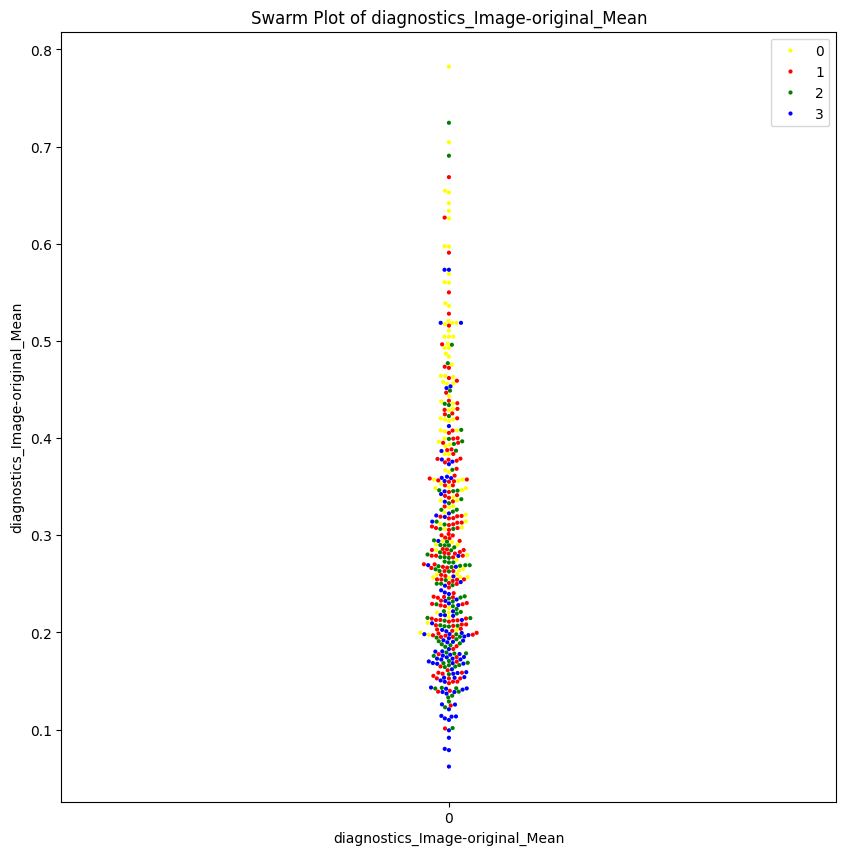

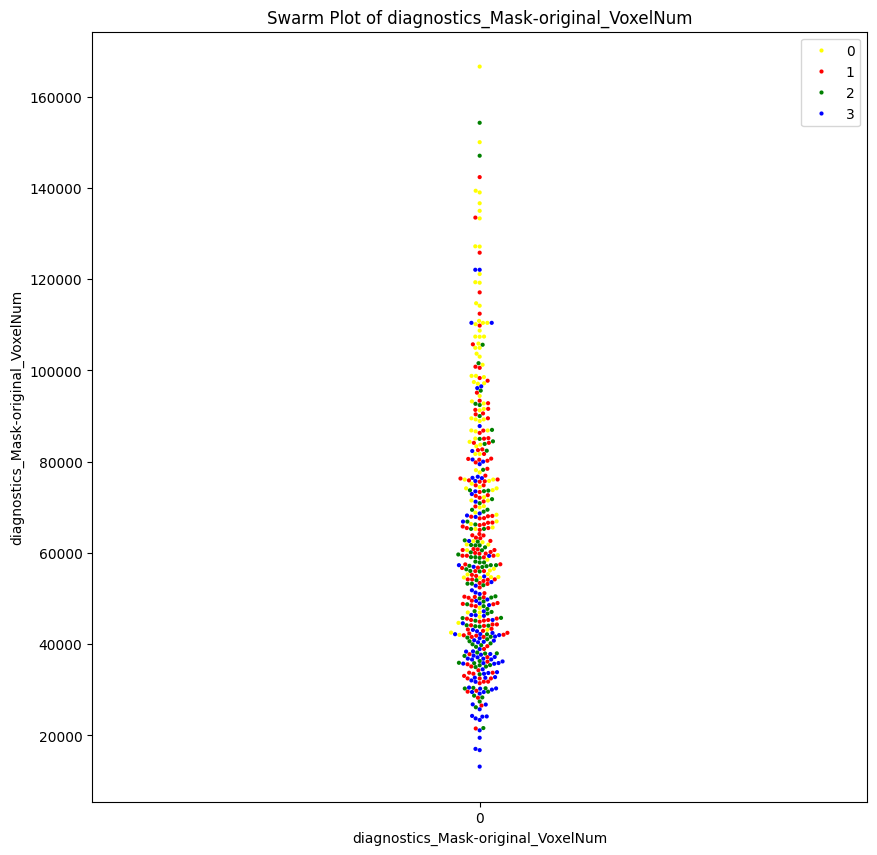

/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:3399: UserWarning: 47.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


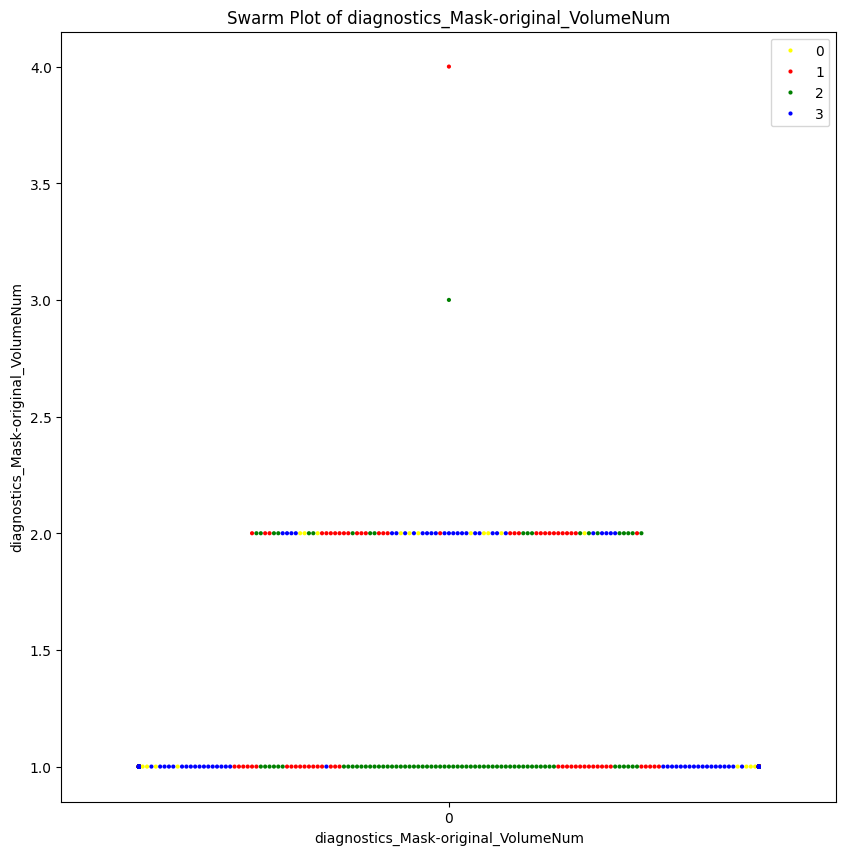

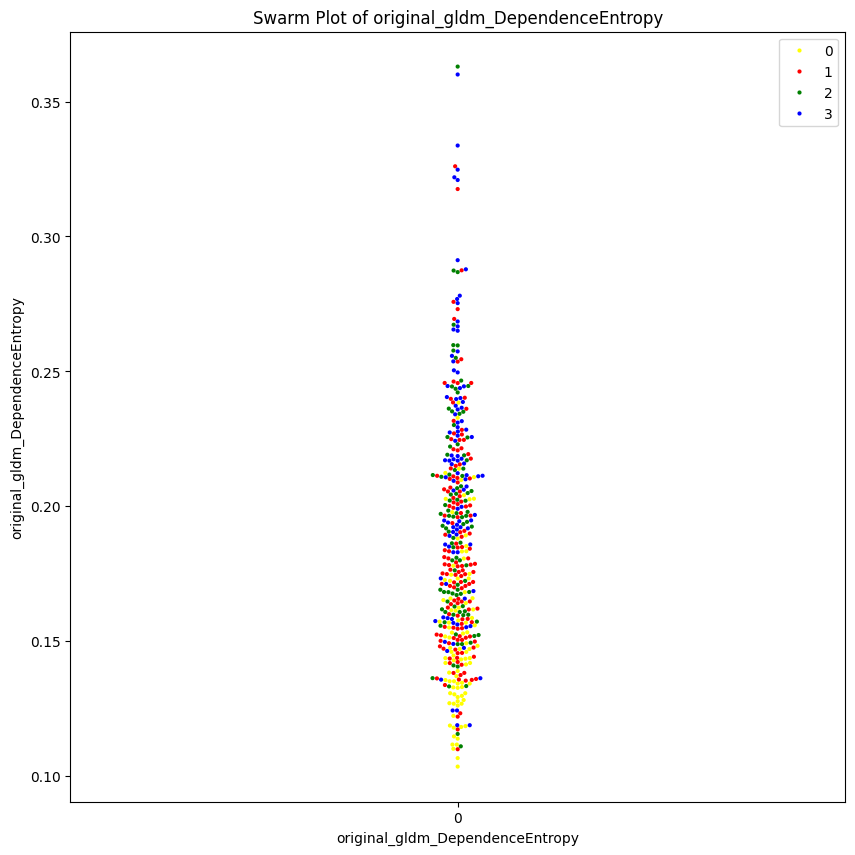

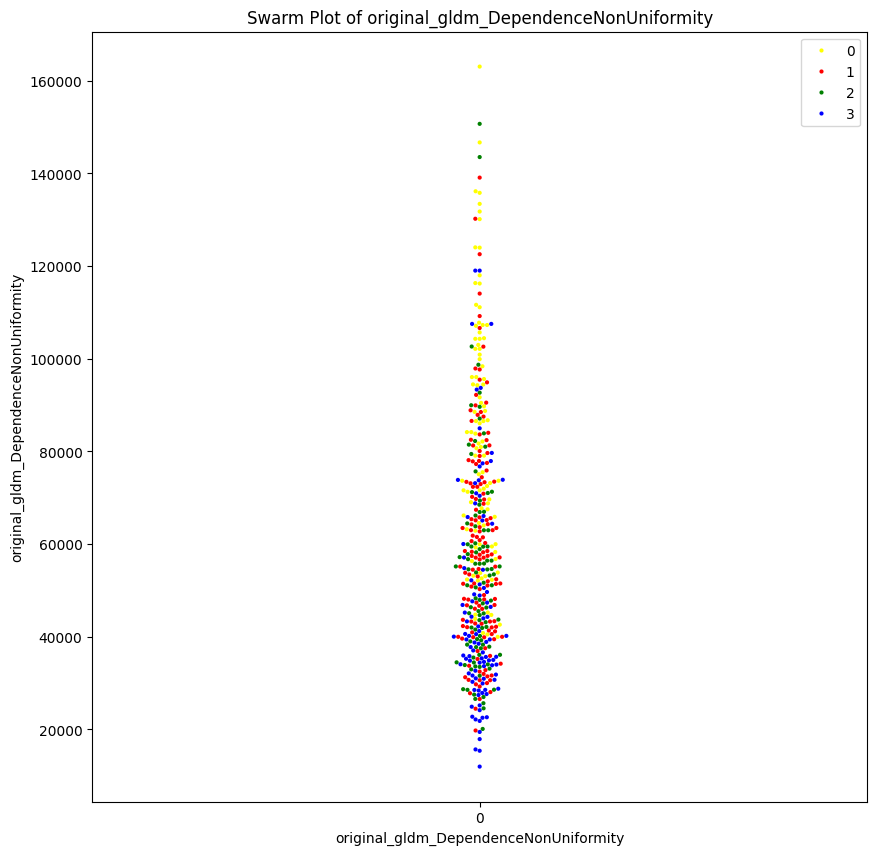

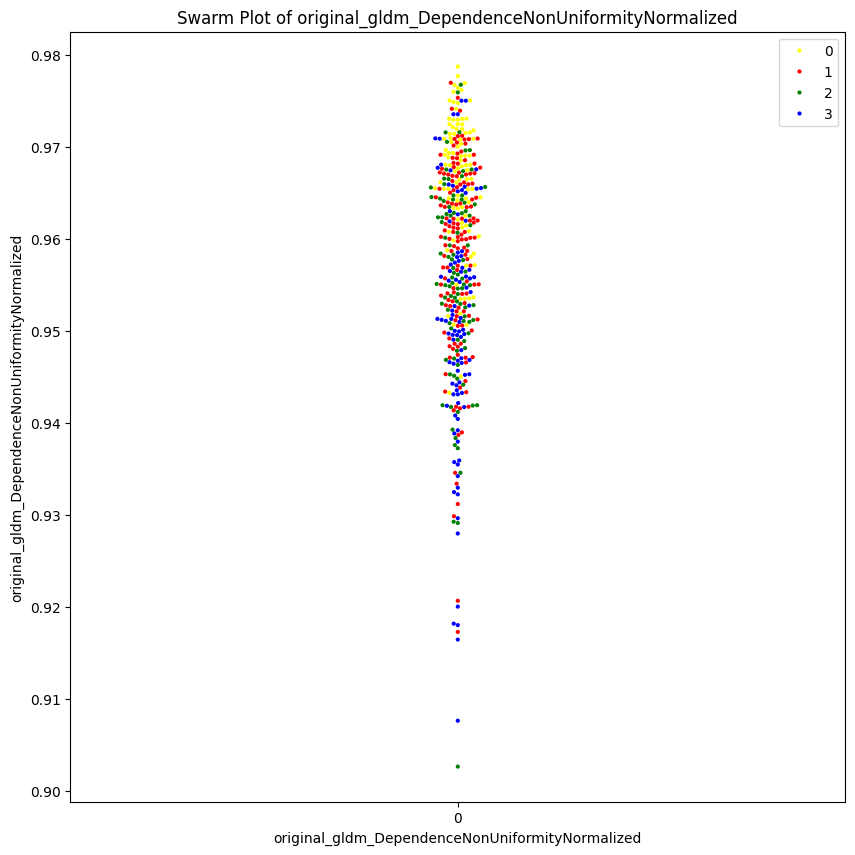

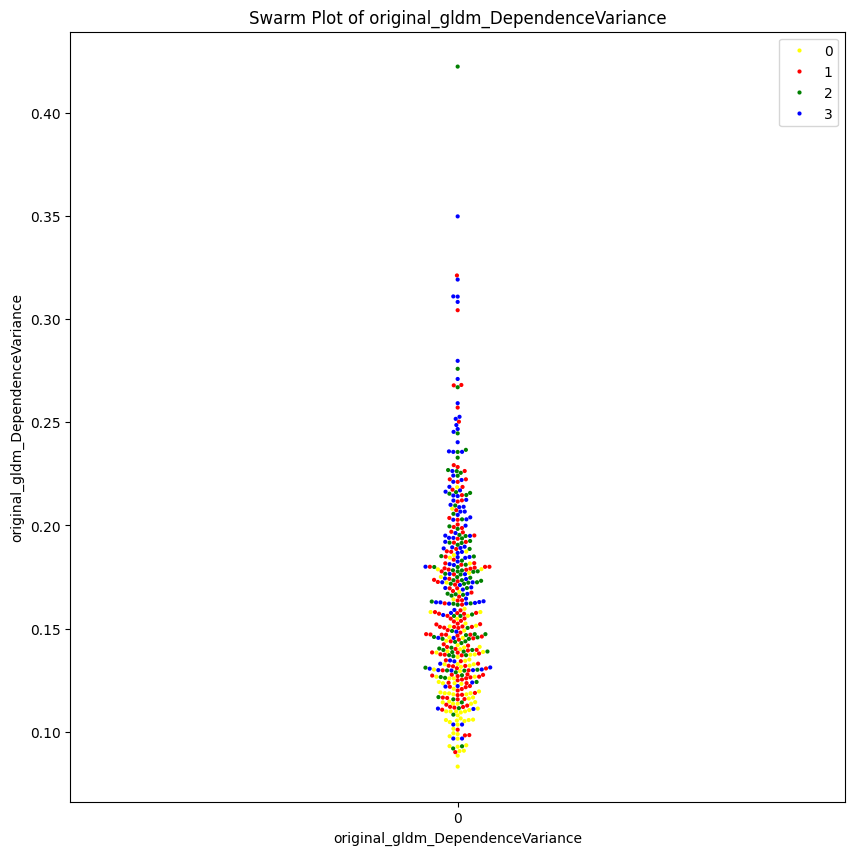

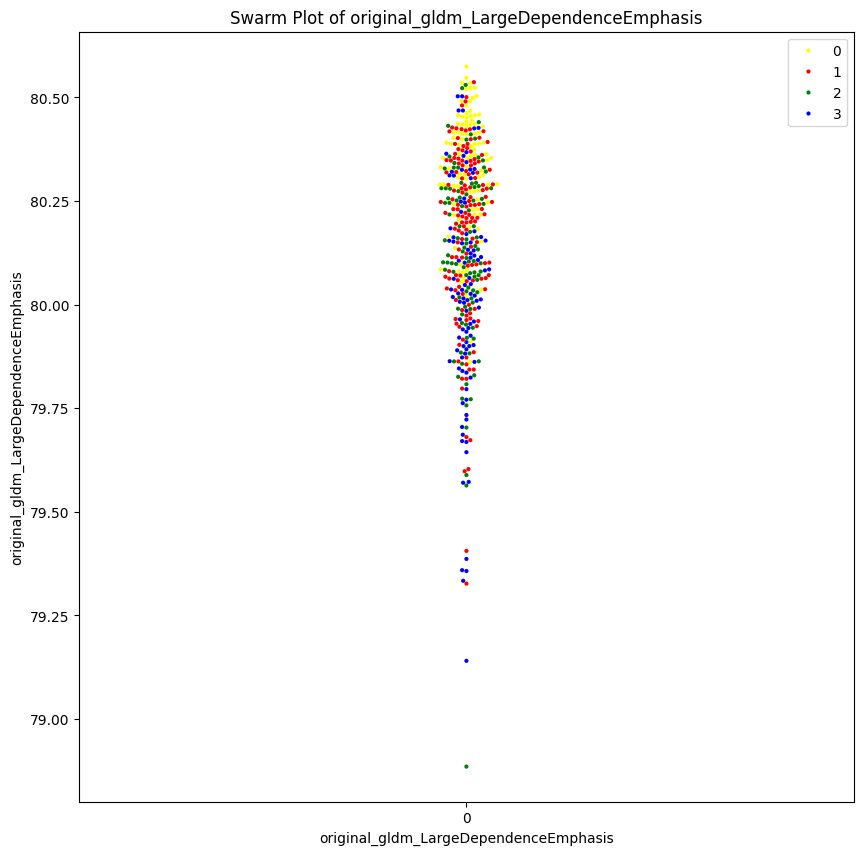

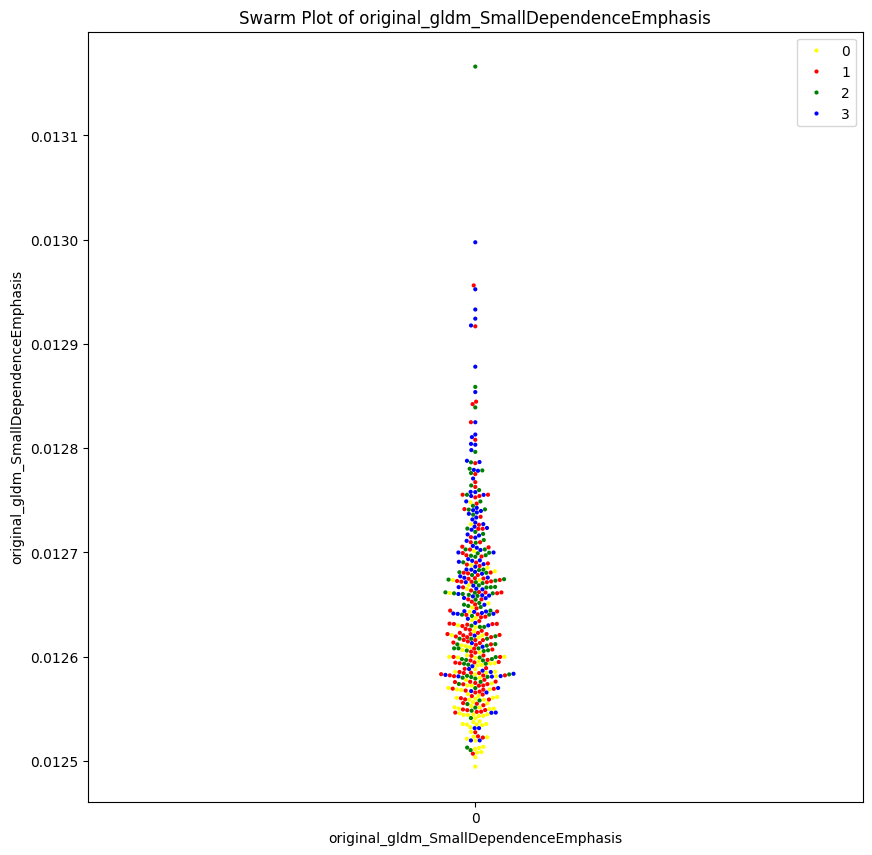

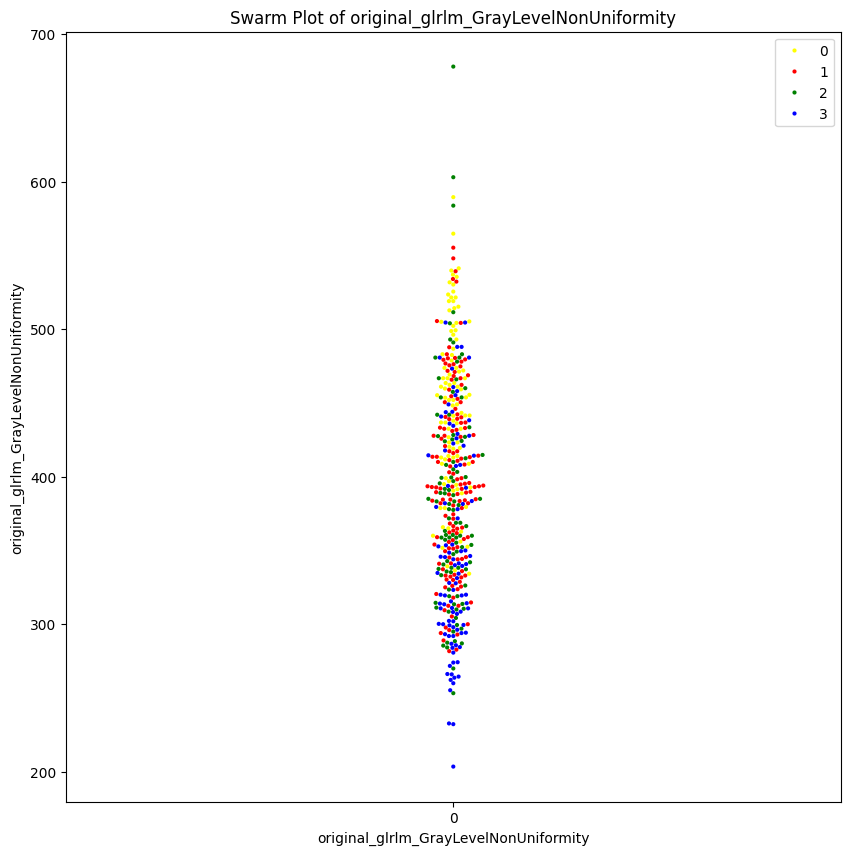

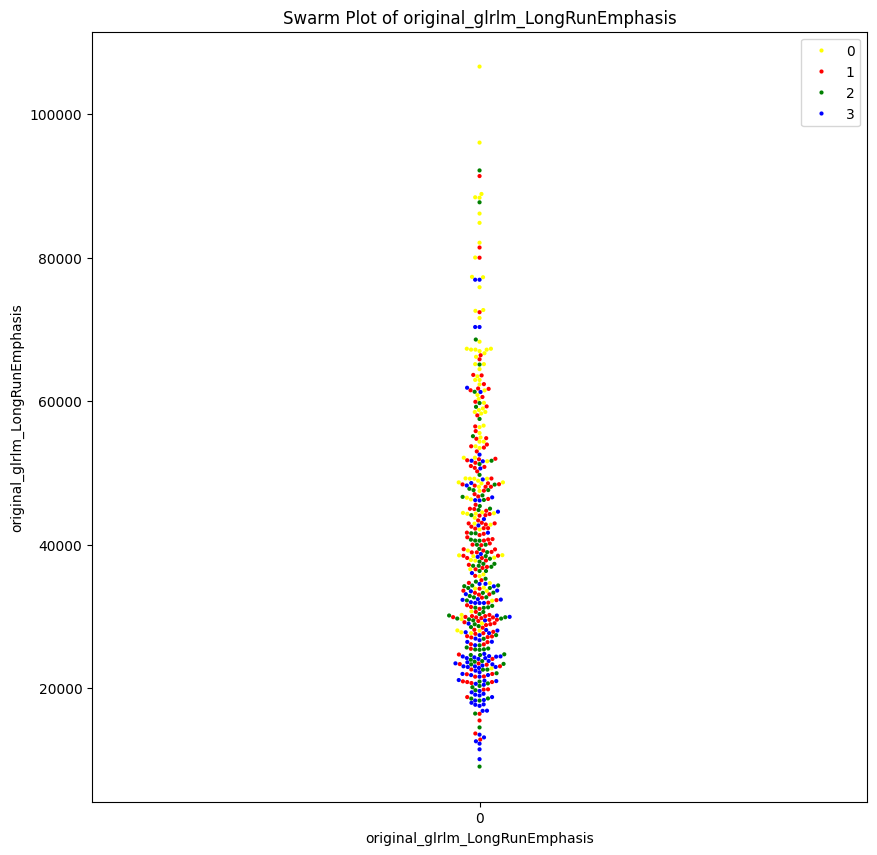

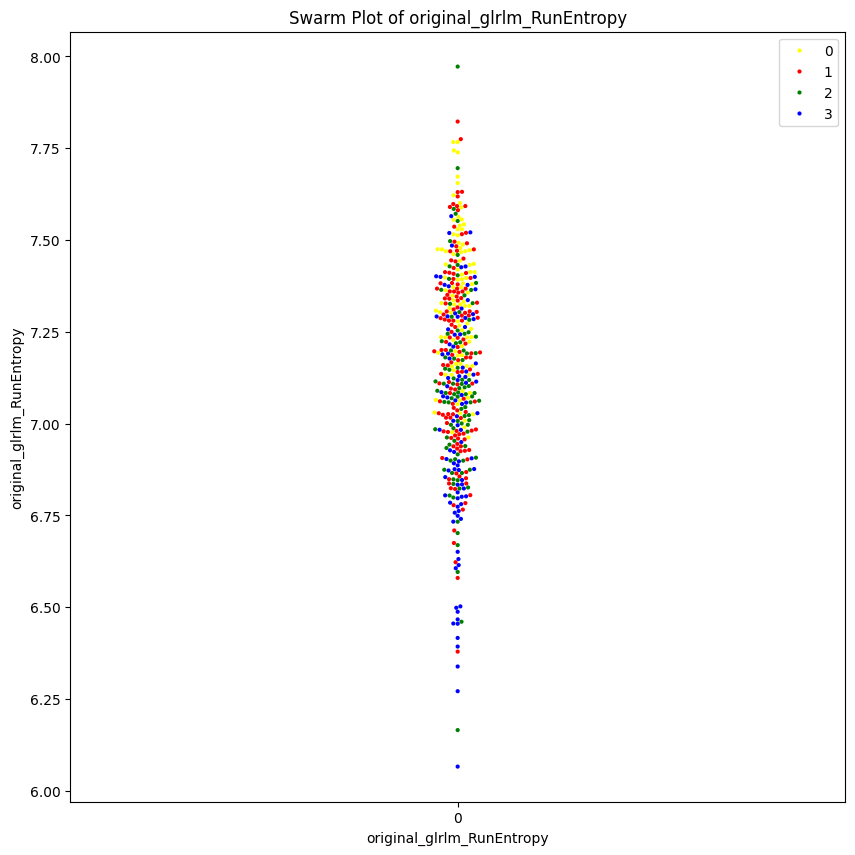

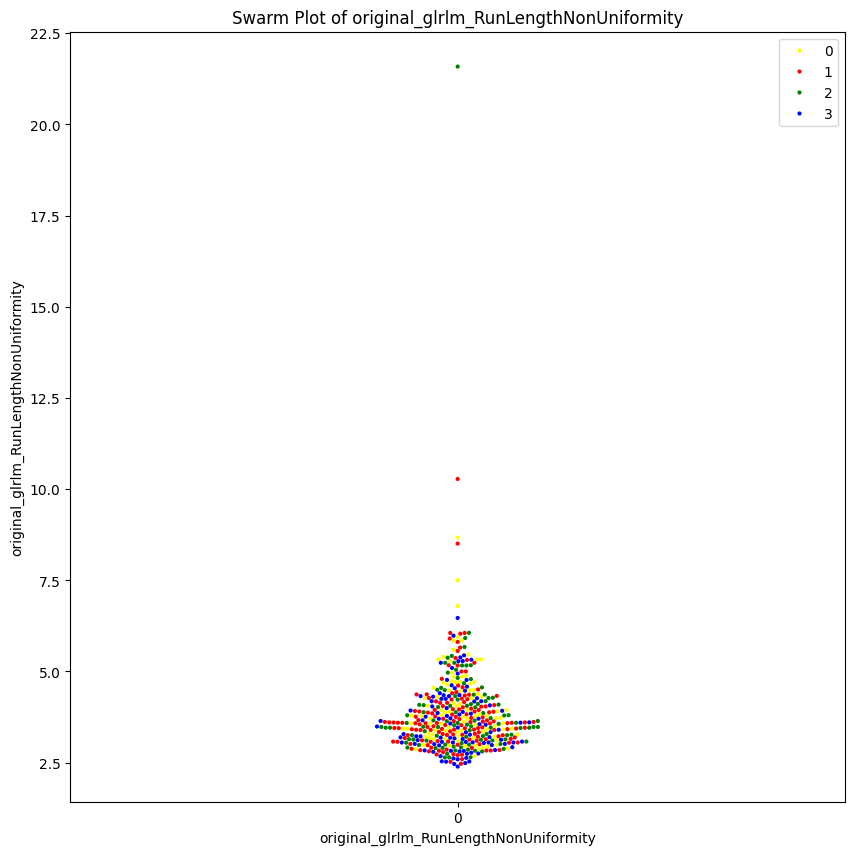

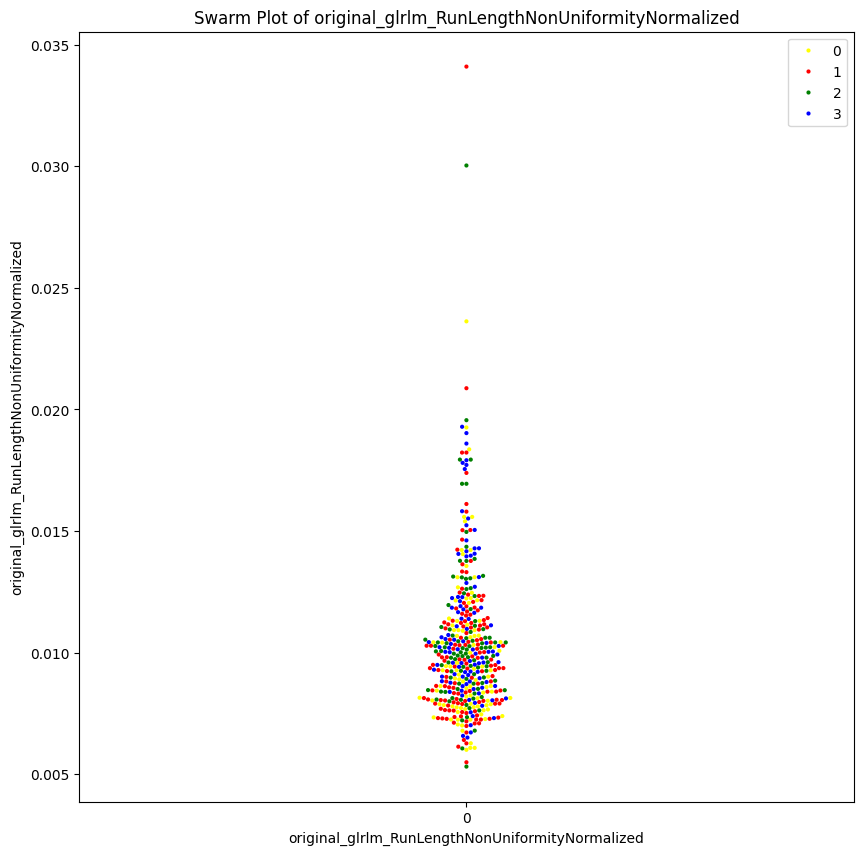

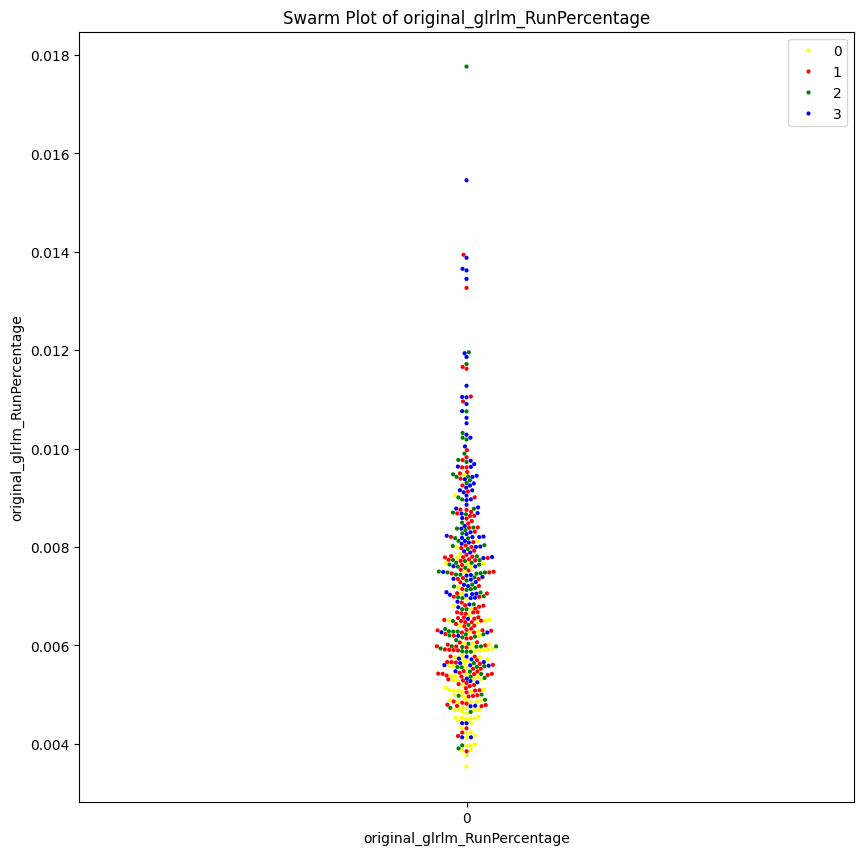

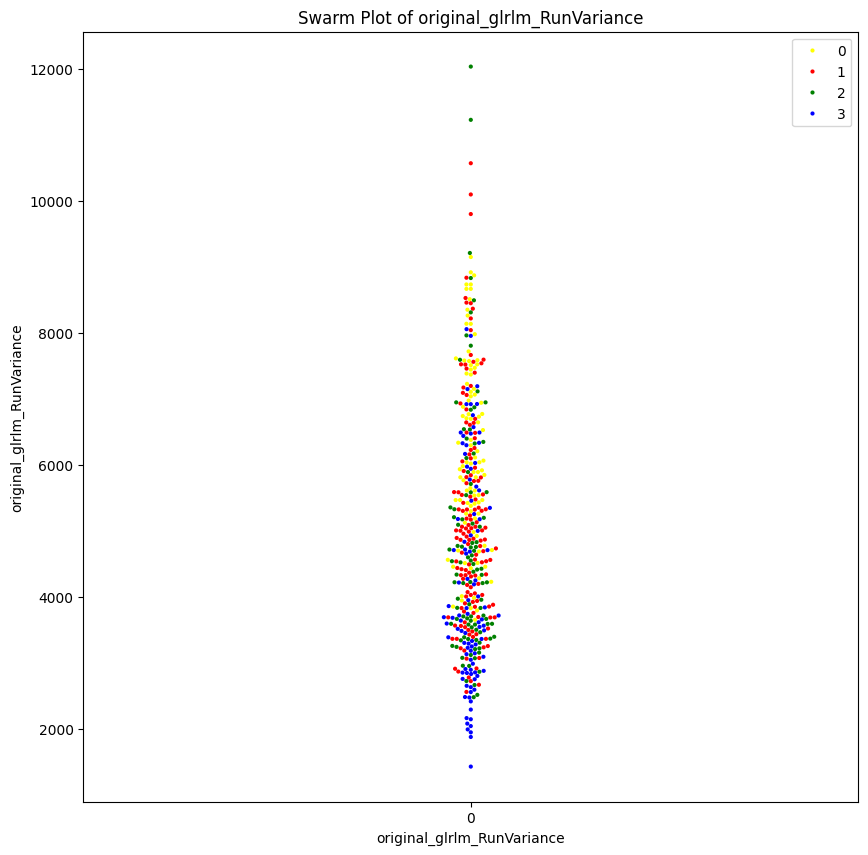

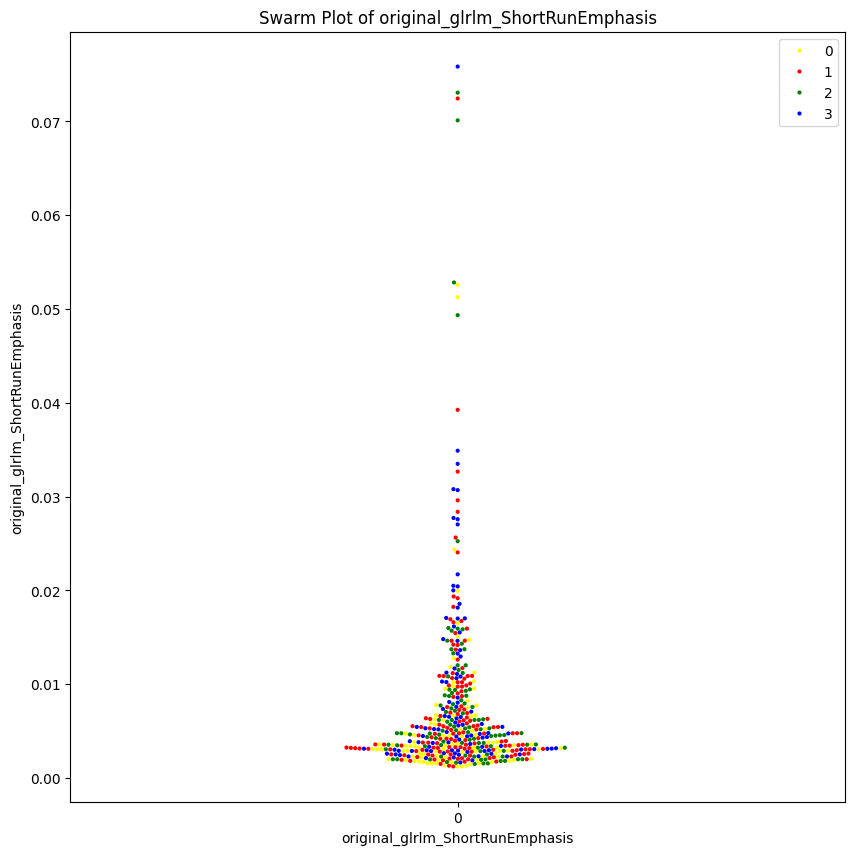

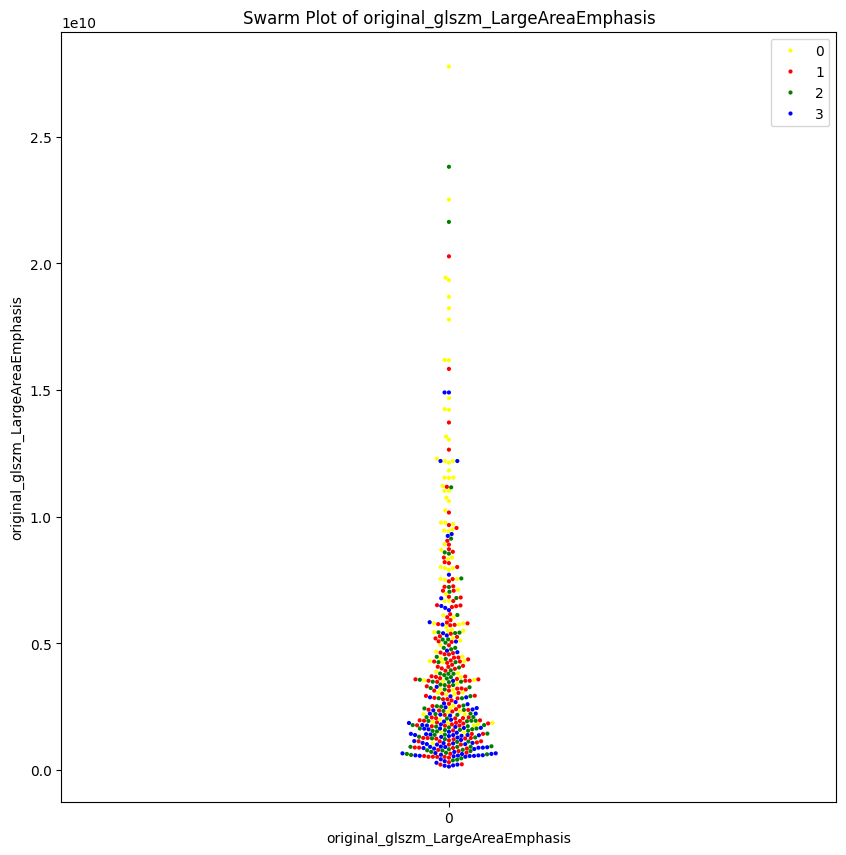

/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:3399: UserWarning: 47.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


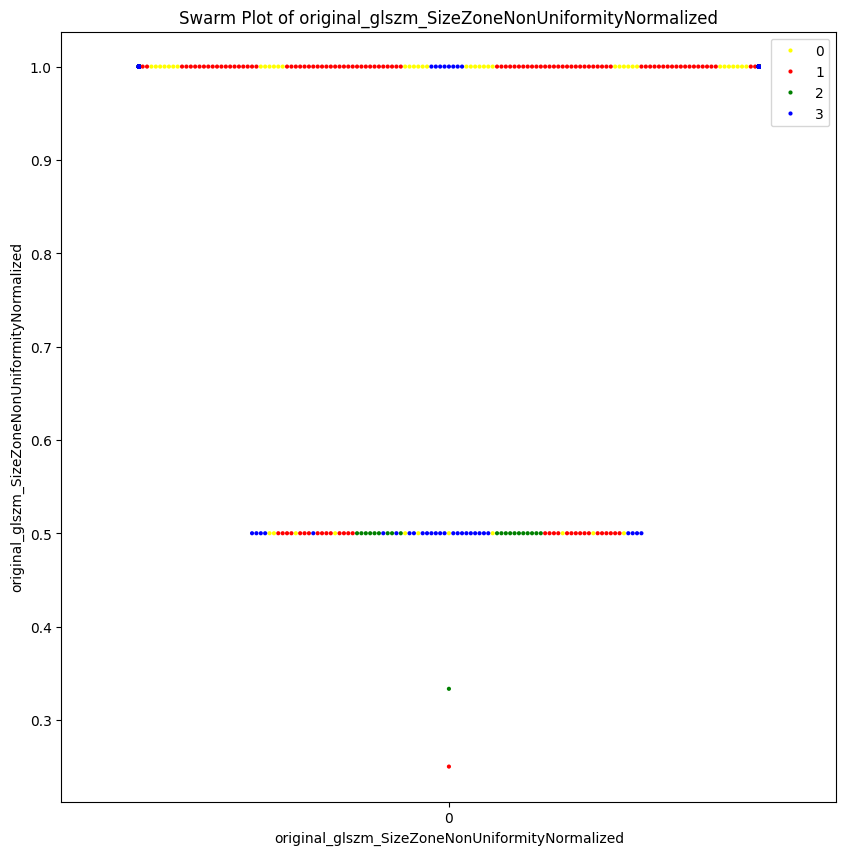

/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:3399: UserWarning: 65.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


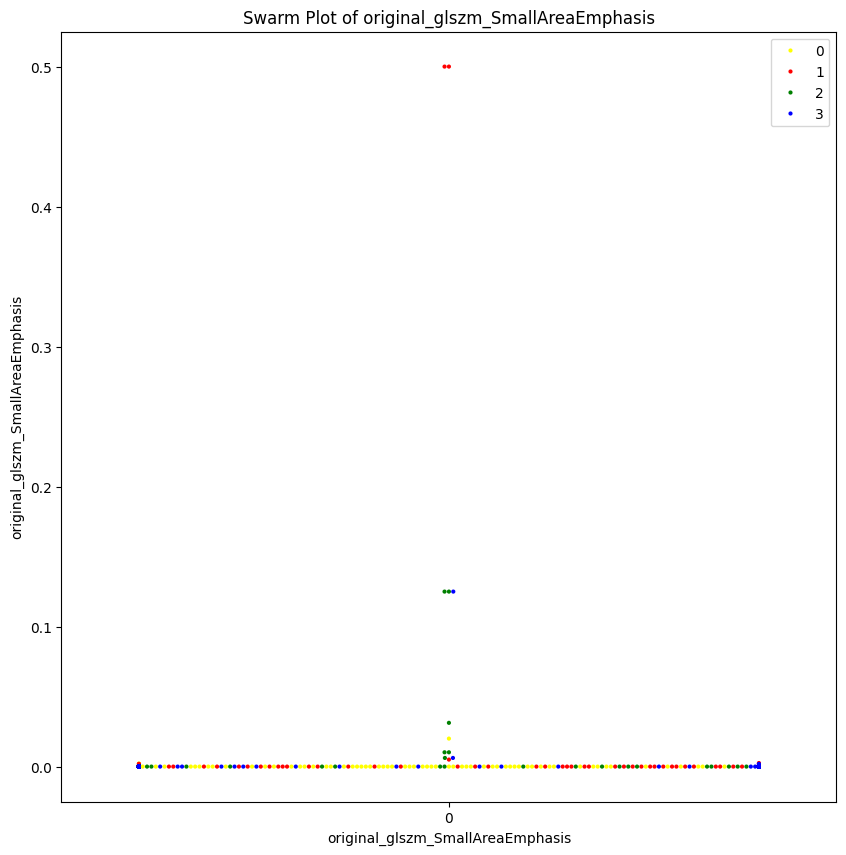

/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:3399: UserWarning: 47.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


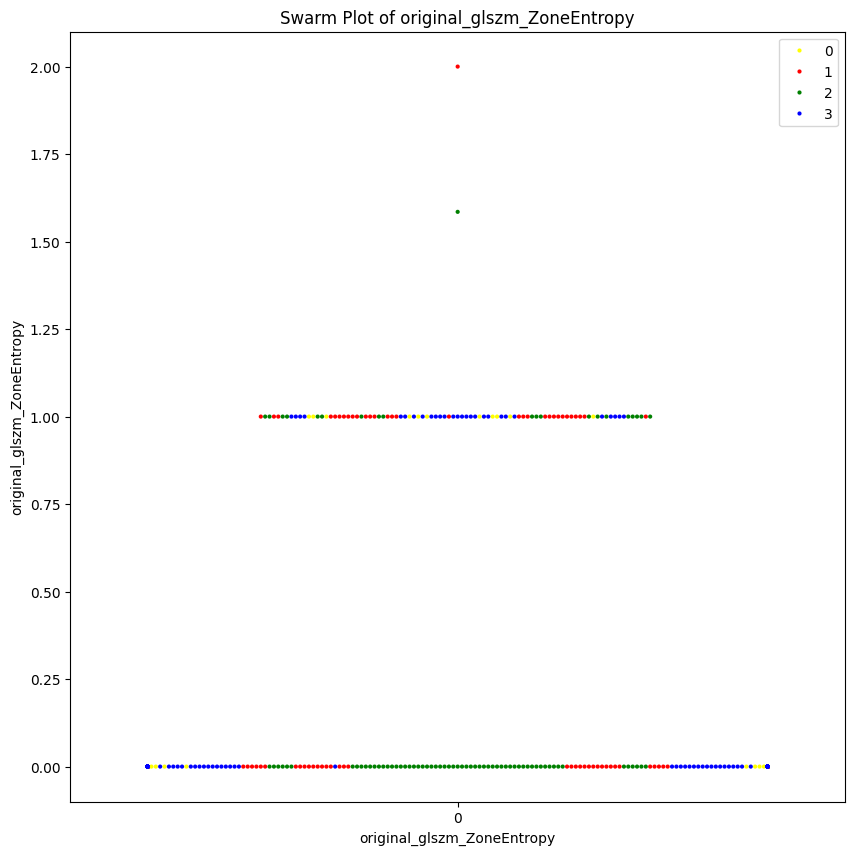

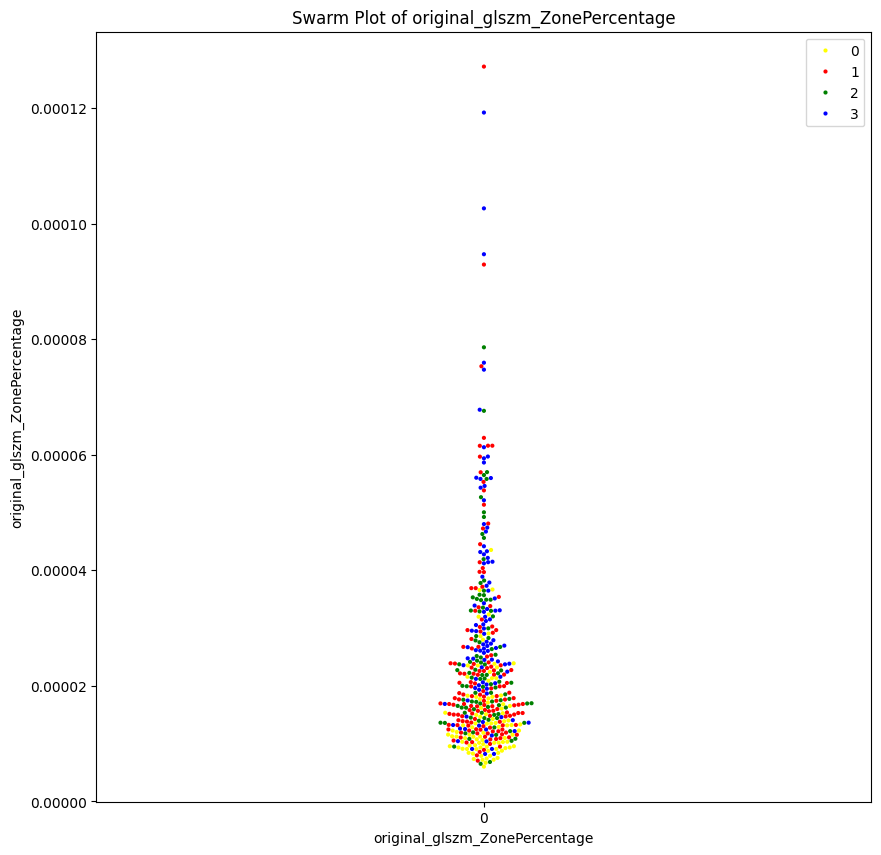

/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:3399: UserWarning: 47.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


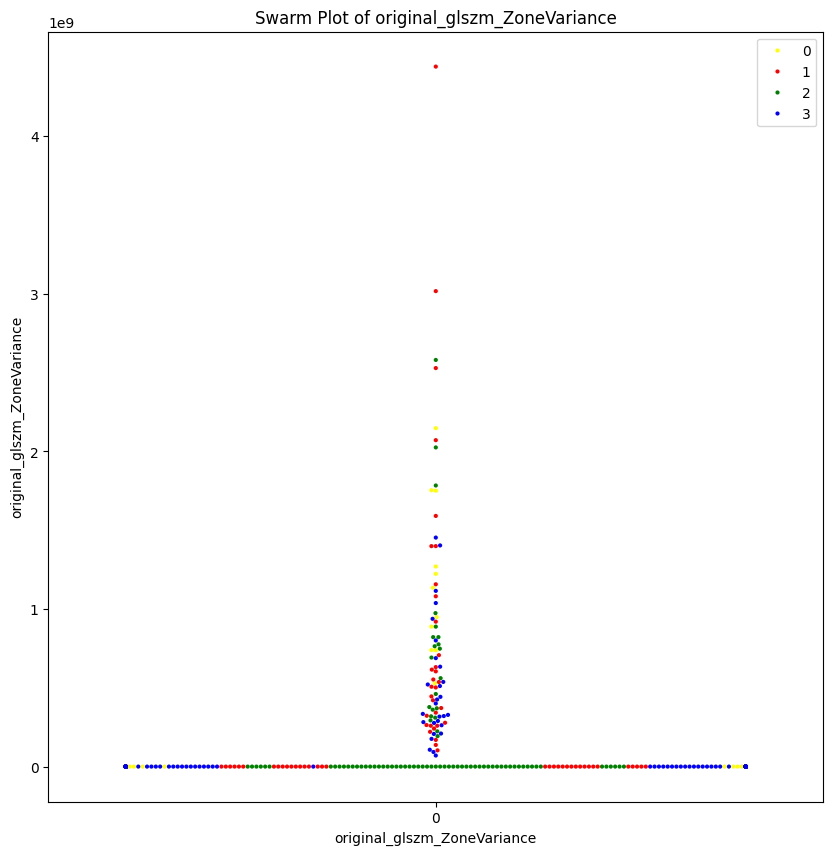

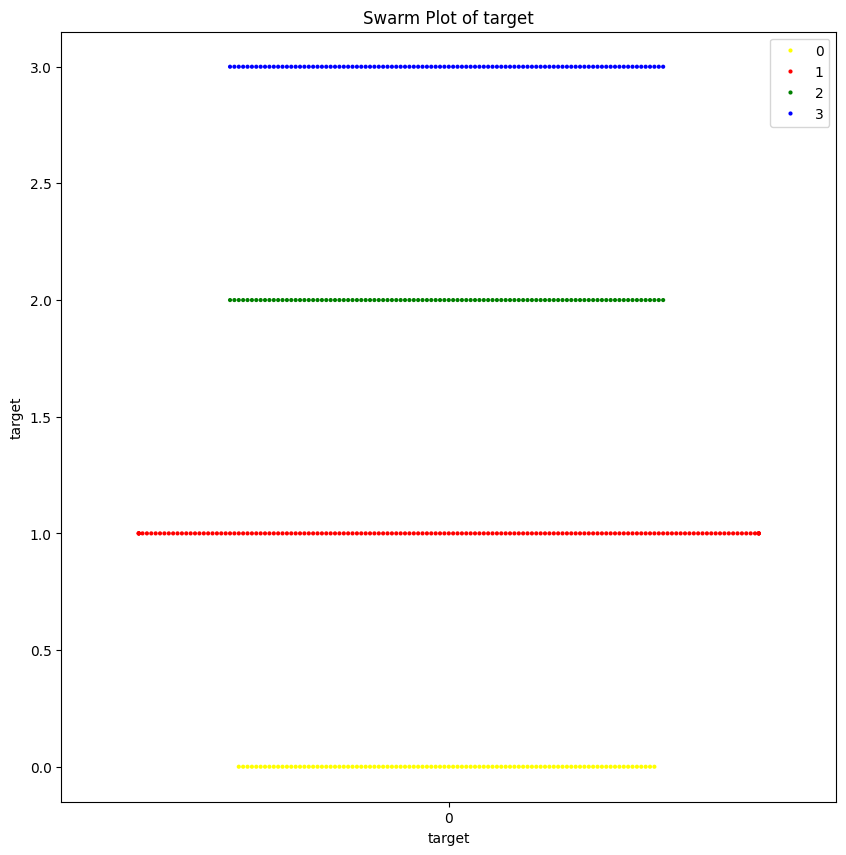

/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:3399: UserWarning: 68.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


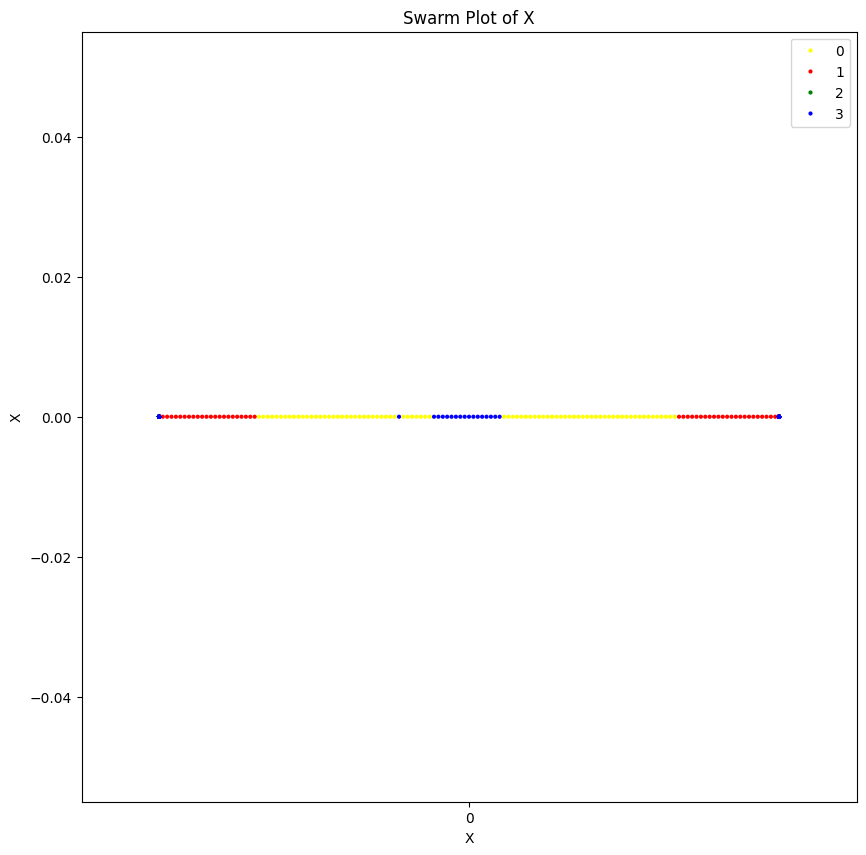

In [34]:
# Visualize the remained features in seaborn plots.

# Add a constant x-axis value for all points.
MG["X"] = 0  # All points will be plotted on x=0

#feature = MG.columns[:len(MG.columns)-2]
feature = MG.columns.tolist()

# Create a swarm plot in one column
for f in feature:
    plt.figure(figsize=(10, 10))
    sns.swarmplot(x="X" , y=f, data=MG, palette={0: 'yellow', 1: 'red', 2: 'green', 3:'blue'}, hue='target', size=3)
    plt.title(f'Swarm Plot of {f}')
    plt.xlabel(f)
    plt.legend()
    plt.show()

In [35]:
# Feature selection.

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif

# Assuming MG is your DataFrame and 'target' is the name of the target column
X = MG.drop(columns=["target"])  # Features (all columns except the target)
y = MG['target']  # Target

selector = SelectKBest(mutual_info_classif, k=5)
selector.fit_transform(X, y)

selected_features = X.columns[selector.get_support()]
MG_kbest          = X[selected_features].copy()

MG_kbest['target'] = y

selected_features

MG_kbest

,diagnostics_Image-original_Mean,diagnostics_Mask-original_VoxelNum,original_gldm_DependenceEntropy,original_gldm_DependenceNonUniformity,original_gldm_DependenceNonUniformityNormalized,target
0,0.462698,98551,0.138304,95625.226786,0.970312,0
1,0.314195,66921,0.162379,64523.073818,0.964168,0
2,0.259545,55281,0.180605,53059.395905,0.959813,0
3,0.328585,69986,0.161724,67494.978681,0.964407,0
4,0.215834,45971,0.202589,43839.600509,0.953636,0
...,...,...,...,...,...,...
440,0.573139,122074,0.118815,119022.815653,0.975005,3
441,0.209308,44581,0.225651,42210.054036,0.946817,3
442,0.322355,68659,0.173251,66047.406676,0.961963,3
443,0.153907,32781,0.230995,30999.130258,0.945643,3


# **Apply a random forest model to classify images into 4 classes using scikit learn library and evaluate the model using confusion matrix**

Cross-validation accuracies: [0.4444444444444444, 0.22580645161290322, 0.3064516129032258, 0.3387096774193548, 0.4032258064516129]
Mean cross-validation accuracy: 0.34372759856630825
Mean cross-validation precision: 0.3635592449384762
Mean cross-validation recall: 0.34372759856630825
Mean cross-validation F1 Score: 0.34442188235004645
Test accuracy: 0.40298507462686567
Test precision: 0.4386045960672827
Test recall: 0.40298507462686567
Test F1 Score: 0.4016453348428993
Test confusion matrix:
 [[17 18  5  2]
 [ 3 21  8  2]
 [ 4  8  3  9]
 [ 3 13  5 13]]


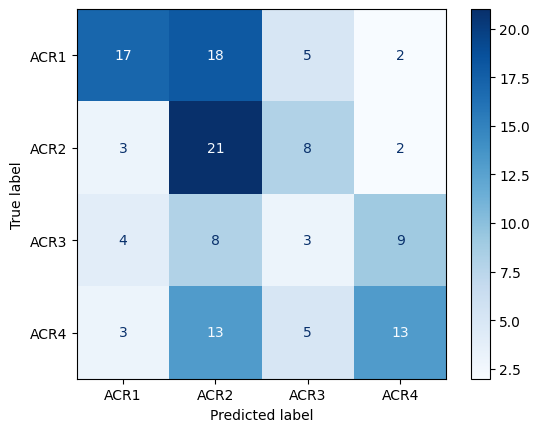

In [36]:
# Separate features (X) and target variable (y)
x = MG_kbest.drop(columns=['target'])
y = MG_kbest['target']

# Splitting the dataset into a training set and a testing set
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

# Initialize the Random Forest model
model = RandomForestClassifier(n_estimators=100, random_state=42)


# K-Fold Cross Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

cross_val_accuracies = []
cross_val_precisions = []
cross_val_recalls    = []
cross_val_f1s        = []


for train_index , val_index in kf.split(X_train):
    X_kf_train, X_kf_val = X_train.iloc[train_index], X_train.iloc[val_index]
    y_kf_train, y_kf_val = y_train.iloc[train_index], y_train.iloc[val_index]

    # Fit the model
    model.fit(X_kf_train, y_kf_train)

    # Predict on the validation set
    y_kf_val_pred = model.predict(X_kf_val)

    # Calculate metrics
    accuracy  = accuracy_score(y_kf_val, y_kf_val_pred)
    precision = precision_score(y_kf_val, y_kf_val_pred, average='weighted')
    recall    = recall_score(y_kf_val, y_kf_val_pred, average='weighted')
    f1        = f1_score(y_kf_val, y_kf_val_pred, average='weighted')

    cross_val_accuracies.append(accuracy)
    cross_val_precisions.append(precision)
    cross_val_recalls.append(recall)
    cross_val_f1s.append(f1)

# Output cross-validation metrics
print("Cross-validation accuracies:"    , cross_val_accuracies)
print("Mean cross-validation accuracy:" , np.mean(cross_val_accuracies))
print("Mean cross-validation precision:", np.mean(cross_val_precisions))
print("Mean cross-validation recall:"   , np.mean(cross_val_recalls))
print("Mean cross-validation F1 Score:" , np.mean(cross_val_f1s))

# Fit the model on the entire training dataset
model.fit(X_train, y_train)

# Test the model on the testing set
y_test_pred = model.predict(X_test)

test_accuracy         = accuracy_score(y_test, y_test_pred)
test_precision        = precision_score(y_test, y_test_pred, average='weighted')
test_recall           = recall_score(y_test, y_test_pred, average='weighted')
test_f1               = f1_score(y_test, y_test_pred, average='weighted')
test_confusion_matrix = confusion_matrix(y_test, y_test_pred)

# Output test metrics
print("Test accuracy:" , test_accuracy)
print("Test precision:", test_precision)
print("Test recall:"   , test_recall)
print("Test F1 Score:" , test_f1)
print("Test confusion matrix:\n", test_confusion_matrix)



confusion_mat_disp = ConfusionMatrixDisplay(test_confusion_matrix, display_labels = ["ACR1" , "ACR2" , "ACR3", "ACR4"])
confusion_mat_disp.plot(cmap='Blues')
plt.show()

# **Random Forest Model using SelectFromModel function**

In [37]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

In [38]:
# Assuming MG is your DataFrame and 'target' is the name of the target column
X = MG.drop(columns=["target"])    # Features (all columns except the target)
y = MG['target']  # Target

model = RandomForestClassifier(n_estimators = 100 ,  random_state=42)
clf   = model.fit(X, y)

selector = SelectFromModel(clf , max_features=5)
selector.fit_transform(X , y);

selected_features = X.columns[selector.get_support()]
MG_RF             = X[selected_features].copy()
MG_RF['target'] = y

In [39]:
selected_features

Index(['original_glrlm_GrayLevelNonUniformity',
       'original_glrlm_LongRunEmphasis', 'original_glrlm_RunEntropy',
       'original_glrlm_RunLengthNonUniformity', 'original_glrlm_RunVariance'],
      dtype='object')

In [40]:
clf.feature_importances_

array([0.05402708, 0.03882018, 0.0027091 , 0.05183911, 0.04647791,
       0.04428753, 0.04336256, 0.04812097, 0.04572294, 0.06189543,
       0.06021866, 0.06117113, 0.06369911, 0.05911133, 0.04257256,
       0.0641497 , 0.05556055, 0.04633838, 0.00225206, 0.04659671,
       0.00216342, 0.04904915, 0.00985445, 0.        ])

In [41]:
MG_RF

,original_glrlm_GrayLevelNonUniformity,original_glrlm_LongRunEmphasis,original_glrlm_RunEntropy,original_glrlm_RunLengthNonUniformity,original_glrlm_RunVariance,target
0,483.00,63451.470490,7.512463,3.728400,7038.629533,0
1,397.00,44307.910115,7.083255,3.940449,4514.826701,0
2,365.75,33847.478965,7.303403,2.892944,4282.936414,0
3,414.00,44410.049331,7.314318,3.218972,5467.044928,0
4,352.50,30182.698310,6.976218,3.880695,4434.734569,0
...,...,...,...,...,...,...
440,504.50,76921.919722,7.399291,4.325235,6919.818591,3
441,392.50,24393.838990,7.114047,3.819532,5613.652124,3
442,449.00,38670.468660,7.152136,6.467802,7148.098211,3
443,294.00,23012.732688,6.748733,3.400419,2632.784051,3


Cross-validation accuracies: [0.4444444444444444, 0.3709677419354839, 0.43548387096774194, 0.4838709677419355, 0.3870967741935484]
Mean cross-validation accuracy: 0.4243727598566308
Mean cross-validation precision: 0.4555971105361897
Mean cross-validation recall: 0.4243727598566308
Mean cross-validation F1 Score: 0.426232670332462
Test accuracy: 0.3805970149253731
Test precision: 0.46826839344660687
Test recall: 0.3805970149253731
Test F1 Score: 0.39213133199914013
Test confusion matrix:
 [[14 24  4  0]
 [ 6 18  7  3]
 [ 1 13  4  6]
 [ 0 12  7 15]]


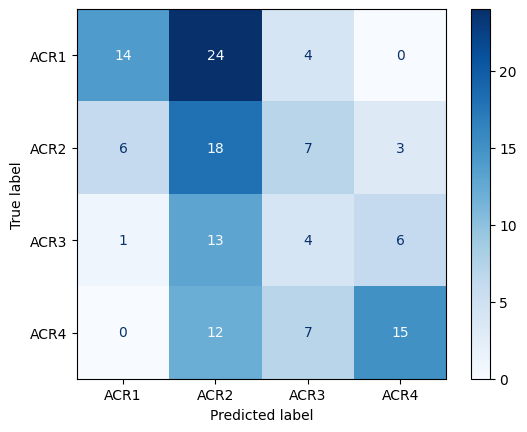

In [42]:
# Separate features (X) and target variable (y)
t = MG_RF.drop(columns=['target'])
y = MG_RF['target']

# Splitting the dataset into a training set and a testing set
X_train, X_test, y_train, y_test = train_test_split(t, y, test_size=0.3, random_state=42)

# Initialize the Random Forest model
model = RandomForestClassifier(n_estimators=100, random_state=42)


# K-Fold Cross Validation
kf = KFold(n_splits=5, shuffle=True, random_state=0)

cross_val_accuracies = []
cross_val_precisions = []
cross_val_recalls    = []
cross_val_f1s        = []


for train_index , val_index in kf.split(X_train):
    X_kf_train, X_kf_val = X_train.iloc[train_index], X_train.iloc[val_index]
    y_kf_train, y_kf_val = y_train.iloc[train_index], y_train.iloc[val_index]

    # Fit the model
    model.fit(X_kf_train, y_kf_train)

    # Predict on the validation set
    y_kf_val_pred = model.predict(X_kf_val)

    # Calculate metrics
    accuracy  = accuracy_score(y_kf_val, y_kf_val_pred)
    precision = precision_score(y_kf_val, y_kf_val_pred, average='weighted')
    recall    = recall_score(y_kf_val, y_kf_val_pred, average='weighted')
    f1        = f1_score(y_kf_val, y_kf_val_pred, average='weighted')

    cross_val_accuracies.append(accuracy)
    cross_val_precisions.append(precision)
    cross_val_recalls.append(recall)
    cross_val_f1s.append(f1)

# Output cross-validation metrics
print("Cross-validation accuracies:"    , cross_val_accuracies)
print("Mean cross-validation accuracy:" , np.mean(cross_val_accuracies))
print("Mean cross-validation precision:", np.mean(cross_val_precisions))
print("Mean cross-validation recall:"   , np.mean(cross_val_recalls))
print("Mean cross-validation F1 Score:" , np.mean(cross_val_f1s))

# Fit the model on the entire training dataset
model.fit(X_train, y_train)

# Test the model on the testing set
y_test_pred = model.predict(X_test)

test_accuracy         = accuracy_score(y_test, y_test_pred)
test_precision        = precision_score(y_test, y_test_pred, average='weighted')
test_recall           = recall_score(y_test, y_test_pred, average='weighted')
test_f1               = f1_score(y_test, y_test_pred, average='weighted')
test_confusion_matrix = confusion_matrix(y_test, y_test_pred)

# Output test metrics
print("Test accuracy:" , test_accuracy)
print("Test precision:", test_precision)
print("Test recall:"   , test_recall)
print("Test F1 Score:" , test_f1)
print("Test confusion matrix:\n", test_confusion_matrix)



confusion_mat_disp = ConfusionMatrixDisplay(test_confusion_matrix, display_labels = ["ACR1" , "ACR2" , "ACR3", "ACR4"])
confusion_mat_disp.plot(cmap='Blues')
plt.show()